# PREPROCESSING:

## План исследования:

1. Импорт данных и библиотек.
2. Определение целей и подхода к исследованию.
3. Первый взгляд на данные.
4. Предобработка признаков (с возможностью повтороной обработки на тестовых данных).
    4.1. Разбиение данных на группы признаков (по типам, особенностям предобработки и т.д.).
    4.2. Обработка данных в разрезе групп, а внутри групп в разрезе признаков (обработка выбросных значений, аномалий, пропусков, приведение типов при необходимости, генерация новых признаков
    и т.д.).
    4.3. Подготовка нескольких обучающих выборок с разными особенностями предобработки.
    4.4. Масштабирование данных.
    4.5. Подготовка тестовой выборки.
5. Подготовка моделей ML.
6. Прикидочное тестирование на разных моделях для оценки перспективности моделей и разных предобработанных train массивов.
7. Тонкая настройка и оптимизация наиболее перспективных моделей ML при использовании наиболее качественных вариантов предобработанных данных.
8. Выбор лучших комбинаций вариант_предобработки/модель/настройки модели для итогового проекта.

### Пояснения по использованию и именованию функций:

Для целей реализации принципов предобработки, определенных при работе над проектом, была разработана система работы с функциями, включающая в себя в том числе систему именования функций.


Принципы предобработки, которые захотел реализовать:

1. Возможность на выходе из этапа предобработки обеспечить несколько обучающих дата-сетов, представляющих собой варианты предобработки исходного дата-сета.
2. Возможность по выбранному в итоге для лучшей комбинации вариант_предобработки/модель полностью восстановить процесс предобработки (с возможность воспроизведения).
3. Легкая, удобная возможность добавления новых вариантов предобработки за счет варьирования, кобминирования, модификации этапов предобработки.


Система работы с функциями:

1. Этапы и подэтапы предобработки инкапсулируются в пользовательских функциях.
2. Полный цикл предобработки, дающий на выходе предобработанный дата-сет - последовательный вызов конкретных пользовательских функций.
3. Вариативность вариантов предобработки определяется конкбинацией вызываемых функций (вызов/не вызов каждой конкретной функции), а так же, в ряде случаев, передаваемыми фукнциям параметрами.
4. Функции работают с переменными train и test, результат, получаемый в результате манипуляций, выполняемых конкретной фукнцией, кладется обратно в эти переменные.


Система именования и использования функций:

1. Имя функции завершается числом (от 0), число определяет порядок следования вызововов функций (на случай если порядок вызова критичен).
2. Функции с префиксом 'm' (must) обязательны к вызову, с префиксом 'o' (optional) не обязательные.
3. Функции, начинающиеся с '_' - вспомогательные, вызывать в общем потоке вызовов не следует.

### Режим работы ноутбука:

In [1]:
cell_by_cell = True  # Вычисления последовательно в ячейках или в ячейке с консолидирующей функцией.

## 1. Импорт данных и библиотек:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [3]:
%matplotlib inline

In [4]:
train_path = 'train.csv'
test_path = 'test.csv'

train = None
test = None
target = None
id = None  # Id test выборки, отделяемый от выборки.

def m_fill_datasets_0():
    global train, test
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)

if cell_by_cell: m_fill_datasets_0()

## 2. Определение целей:

Цели проекта:
1. Основная: обучить модель данных, ожидаемая эффективность которой по метрике R2 > 0.74.
2. Дополнительная: занять 1 место в рейтинге kaggle по данному соревнованию.

## 3. Первый взгляд на данные:

In [5]:
train.columns, test.columns

(Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
        'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
        'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
        'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
       dtype='object'),
 Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
        'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
        'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
        'Helthcare_2', 'Shops_1', 'Shops_2'],
       dtype='object'))

In [6]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500

(None, None)

In [7]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [8]:
test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [9]:
train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


## 4. Предобработка признаков:

### 4.1. Разбиение данных на группы признаков:

Группы признаков:

Номинативные:

In [10]:
train.select_dtypes(include=['object']).columns, 'DistrictId'

(Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object'), 'DistrictId')

Количественные:

In [11]:
'Количественные:', train.select_dtypes(exclude=['object']).drop(columns=['DistrictId', 'Id']).columns

('Количественные:',
 Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
        'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
        'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price'],
       dtype='object'))

### 4.2. Обработка данных в разрезе групп, а внутри групп в разрезе признаков:

### Id

Удаляем неинформативный столбец Id.

In [12]:
train.columns, test.columns

(Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
        'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
        'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
        'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
       dtype='object'),
 Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
        'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
        'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
        'Helthcare_2', 'Shops_1', 'Shops_2'],
       dtype='object'))

In [13]:
def m_del_id_from_train_1():  # Удаляем из train выборки признак Id.
    global train, test
    if 'Id' in train.columns:
        train.drop(columns='Id', inplace=True)
        return True
    return False

if cell_by_cell: m_del_id_from_train_1()

### Обработка номинативных признаков:

### Оценка вариативности номинативных признаков:

In [14]:
train.select_dtypes(include=['object']).columns

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

In [15]:
train['Ecology_2'].unique(), train['Ecology_3'].unique(), train['Shops_2'].unique()

(array(['B', 'A'], dtype=object),
 array(['B', 'A'], dtype=object),
 array(['B', 'A'], dtype=object))

In [16]:
test['Ecology_2'].unique(), test['Ecology_3'].unique(), test['Shops_2'].unique()

(array(['B', 'A'], dtype=object),
 array(['B', 'A'], dtype=object),
 array(['B', 'A'], dtype=object))

### Замещение номинативных признаков бинарными количественными.

### Ecology_2,   Ecology_3,   Shops_2

In [17]:
def _replace_with_binary(dataset, feature):  # Замена номитанивных признаков на бинарные количественные
    dataset.loc[dataset[feature] == 'B', feature] = 1
    dataset.loc[dataset[feature] == 'A', feature] = 0

def m_replace_nominative_with_binary_2():  # Замена бинарных номинативных признаков на количественные бинарные.
    global train, test
    _replace_with_binary(train, 'Ecology_2')
    _replace_with_binary(train, 'Ecology_3')
    _replace_with_binary(train, 'Shops_2')

    _replace_with_binary(test, 'Ecology_2')
    _replace_with_binary(test, 'Ecology_3')
    _replace_with_binary(test, 'Shops_2')

if cell_by_cell: m_replace_nominative_with_binary_2()

In [18]:
train['Ecology_2'].value_counts(), train['Ecology_3'].value_counts(), train['Shops_2'].value_counts(), test['Ecology_2'].value_counts(), test['Ecology_2'].value_counts(), test['Shops_2'].value_counts()

(1    9903
 0      97
 Name: Ecology_2, dtype: int64, 1    9725
 0     275
 Name: Ecology_3, dtype: int64, 1    9175
 0     825
 Name: Shops_2, dtype: int64, 1    4952
 0      48
 Name: Ecology_2, dtype: int64, 1    4952
 0      48
 Name: Ecology_2, dtype: int64, 1    4588
 0     412
 Name: Shops_2, dtype: int64)

In [19]:
train.head(10)
train.corr()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
DistrictId,1.000000,0.071432,-0.026613,-0.019910,0.040358,-0.120373,-0.149051,0.013430,0.065294,-0.093406,-0.027902,0.246463,0.167479,0.136095,0.304335,0.306147,0.174214,-0.021018,0.265100
Rooms,0.071432,1.000000,0.662893,0.131336,0.005123,-0.000665,-0.029302,-0.010612,-0.032347,-0.001971,-0.005909,0.075980,0.071335,0.012811,0.042857,0.063557,0.053618,-0.000146,0.550291
Square,-0.026613,0.662893,1.000000,0.196129,0.008320,0.114791,0.081505,-0.009032,-0.064479,0.029926,0.022748,-0.070690,-0.043120,0.035241,-0.039748,-0.022960,0.021357,-0.049380,0.520075
LifeSquare,-0.019910,0.131336,0.196129,1.000000,-0.001195,0.024559,0.027442,-0.002210,-0.023629,0.006808,0.008597,-0.048363,-0.039283,0.012763,-0.026867,-0.024762,-0.007569,-0.004692,0.081292
KitchenSquare,0.040358,0.005123,0.008320,-0.001195,1.000000,-0.011397,0.000780,0.000958,-0.005622,0.000268,-0.007919,0.043379,0.037805,-0.015140,0.009472,0.043170,0.010216,-0.017315,0.028864
Floor,-0.120373,-0.000665,0.114791,0.024559,-0.011397,1.000000,0.418986,0.000928,-0.016133,0.049661,0.025767,-0.044914,-0.016560,-0.002237,-0.138294,-0.065537,0.024264,-0.013626,0.128715
HouseFloor,-0.149051,-0.029302,0.081505,0.027442,0.000780,0.418986,1.000000,-0.000864,-0.004362,0.059347,0.009258,-0.020801,0.007194,-0.008137,-0.143973,-0.068728,0.026279,0.051002,0.088280
HouseYear,0.013430,-0.010612,-0.009032,-0.002210,0.000958,0.000928,-0.000864,1.000000,0.001465,0.000997,0.001686,0.003026,0.001970,0.000819,-0.011969,0.011245,0.003681,0.002994,0.004305
Ecology_1,0.065294,-0.032347,-0.064479,-0.023629,-0.005622,-0.016133,-0.004362,0.001465,1.000000,-0.110725,-0.223197,0.026464,0.009264,-0.124068,-0.043547,0.030873,-0.076749,0.079809,-0.058381
Ecology_2,-0.093406,-0.001971,0.029926,0.006808,0.000268,0.049661,0.059347,0.000997,-0.110725,1.000000,-0.016643,-0.066017,-0.012709,0.008512,-0.031724,-0.082667,0.051892,0.022242,0.022379


### DistrictId

In [20]:
def m_process_districtid_3(param):
    global train, test
    if param == 'delete':
        if 'DistrictId' in train.columns:
            train.drop(columns='DistrictId', inplace=True)
        if 'DistrictId' in test.columns:
            test.drop(columns='DistrictId', inplace=True)
    elif param == 'dummy':
        train = pd.concat([train, pd.get_dummies(train['DistrictId'])], axis=1)
        test = pd.concat([test, pd.get_dummies(test['DistrictId'])], axis=1)
        
        del_tst = [198, 203, 204, 206, 210, 211, 212]
        del_trn = [117, 133, 158, 162, 174, 195, 199, 201, 202, 207, 50]
        test.drop(columns=del_tst, inplace=True)  # Видимо, признаки со всеми нулями не попадают, уравниваю выборки по призн.
        train.drop(columns=del_trn, inplace=True)  # Хотя, пожалуй, лучше делать это более универсальными способами.

if cell_by_cell: m_process_districtid_3('delete')

In [21]:
train.head(3)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,NaN,0,11,1,184966.930730
1,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,300009.450063
2,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,220925.908524


### Обработка количественных признаков:

### Rooms

In [22]:
train.Rooms.value_counts().sort_index(), test.Rooms.value_counts().sort_index()

(0.0        8
 1.0     3705
 2.0     3880
 3.0     2235
 4.0      150
 5.0       18
 6.0        1
 10.0       2
 19.0       1
 Name: Rooms, dtype: int64, 0.0        2
 1.0     1769
 2.0     2030
 3.0     1099
 4.0       90
 5.0        7
 6.0        2
 17.0       1
 Name: Rooms, dtype: int64)

(array([2.000e+00, 1.769e+03, 2.030e+03, 1.099e+03, 9.000e+01, 7.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 0.  ,  0.85,  1.7 ,  2.55,  3.4 ,  4.25,  5.1 ,  5.95,  6.8 ,
         7.65,  8.5 ,  9.35, 10.2 , 11.05, 11.9 , 12.75, 13.6 , 14.45,
        15.3 , 16.15, 17.  ]),
 <a list of 20 Patch objects>)

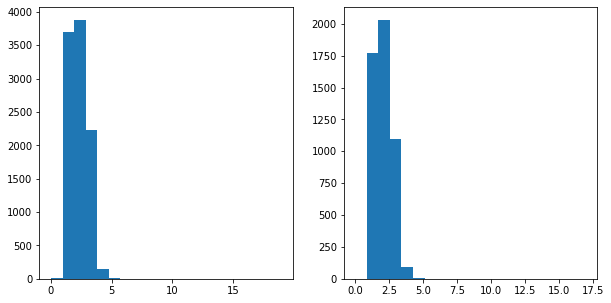

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10, 5)
ax1, ax2 = ax.flatten()
ax1.hist(train['Rooms'], bins=20)
ax2.hist(test['Rooms'], bins=20)

In [24]:
train.loc[train['Rooms'] > 5, :].sort_values(by='Rooms', ascending=False)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1454,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,1,1,1,264,0,NaN,0,1,1,78364.616704
377,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,1,1,74,19083,2,NaN,5,15,1,317265.323792
8849,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,1,1,25,5648,1,30.0,2,4,1,172329.270863
2170,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,1,1,66,10573,1,1322.0,3,8,1,229661.964416


In [25]:
train.corr()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Rooms,1.000000,0.662893,0.131336,0.005123,-0.000665,-0.029302,-0.010612,-0.032347,-0.001971,-0.005909,0.075980,0.071335,0.012811,0.042857,0.063557,0.053618,-0.000146,0.550291
Square,0.662893,1.000000,0.196129,0.008320,0.114791,0.081505,-0.009032,-0.064479,0.029926,0.022748,-0.070690,-0.043120,0.035241,-0.039748,-0.022960,0.021357,-0.049380,0.520075
LifeSquare,0.131336,0.196129,1.000000,-0.001195,0.024559,0.027442,-0.002210,-0.023629,0.006808,0.008597,-0.048363,-0.039283,0.012763,-0.026867,-0.024762,-0.007569,-0.004692,0.081292
KitchenSquare,0.005123,0.008320,-0.001195,1.000000,-0.011397,0.000780,0.000958,-0.005622,0.000268,-0.007919,0.043379,0.037805,-0.015140,0.009472,0.043170,0.010216,-0.017315,0.028864
Floor,-0.000665,0.114791,0.024559,-0.011397,1.000000,0.418986,0.000928,-0.016133,0.049661,0.025767,-0.044914,-0.016560,-0.002237,-0.138294,-0.065537,0.024264,-0.013626,0.128715
HouseFloor,-0.029302,0.081505,0.027442,0.000780,0.418986,1.000000,-0.000864,-0.004362,0.059347,0.009258,-0.020801,0.007194,-0.008137,-0.143973,-0.068728,0.026279,0.051002,0.088280
HouseYear,-0.010612,-0.009032,-0.002210,0.000958,0.000928,-0.000864,1.000000,0.001465,0.000997,0.001686,0.003026,0.001970,0.000819,-0.011969,0.011245,0.003681,0.002994,0.004305
Ecology_1,-0.032347,-0.064479,-0.023629,-0.005622,-0.016133,-0.004362,0.001465,1.000000,-0.110725,-0.223197,0.026464,0.009264,-0.124068,-0.043547,0.030873,-0.076749,0.079809,-0.058381
Ecology_2,-0.001971,0.029926,0.006808,0.000268,0.049661,0.059347,0.000997,-0.110725,1.000000,-0.016643,-0.066017,-0.012709,0.008512,-0.031724,-0.082667,0.051892,0.022242,0.022379
Ecology_3,-0.005909,0.022748,0.008597,-0.007919,0.025767,0.009258,0.001686,-0.223197,-0.016643,1.000000,-0.037777,0.007394,0.014595,-0.114715,-0.133120,0.001859,-0.050425,-0.052585


### Базовые функции-обработчики выбросов:

In [26]:
def _process_outliers_higher(param, edge, feature):  # Базовый обработчик выбросов сверху.
    global train, test
    edge = edge
    feature = feature
    if param == 'to_median':
        train.loc[train[feature] > edge, feature] = train[feature].median()
        test.loc[test[feature] > edge, feature] = test[feature].median()
    if param == 'to_edge':
        train.loc[train[feature] > edge, feature] = edge
        test.loc[test[feature] > edge, feature] = edge
    if param == 'delete':
        train.drop(axis=0, index=train.loc[train[feature] > 1, feature].index, inplace=True)
        test.drop(axis=0, index=test.loc[test[feature] > 1, feature].index, inplace=True)

def _process_outliers_lower(param, edge, feature):  # Базовый обработчик выбросов снизу.
    global train, test
    edge = edge
    feature = feature
    if param == 'to_median':
        train.loc[train[feature] > edge, feature] = train[feature].median()
        test.loc[test[feature] > edge, feature] = test[feature].median()
    if param == 'to_edge':
        train.loc[train[feature] > edge, feature] = edge
        test.loc[test[feature] > edge, feature] = edge
    if param == 'delete':
        train.drop(axis=0, index=train.loc[train[feature] > 1, feature].index, inplace=True)
        test.drop(axis=0, index=test.loc[test[feature] > 1, feature].index, inplace=True)


In [27]:
def m_rooms_outliers_process_5(param, edge):  # Обрабатываем выбросы по Rooms
    global train, test
    _process_outliers_higher(param=param, edge=edge, feature='Rooms')

if cell_by_cell: m_rooms_outliers_process_5('to_edge', 5)

In [28]:
train.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,NaN,0,11,1,184966.930730
1,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,300009.450063
2,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,220925.908524
3,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217
4,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1,150226.531644


### LifeSquare - outliers

In [29]:
def m_lifesquare_process_outliers_6(param, edge):
    global train, test
    _process_outliers_higher(param=param, edge=edge, feature='LifeSquare')
    
if cell_by_cell: m_lifesquare_process_outliers_6('to_median', 1000)

### KitchenSquare - outliers

In [30]:
def m_kitchensquare_process_outliers_6(param, edge):
    global train, test
    _process_outliers_higher(param=param, edge=edge, feature='KitchenSquare')
    
if cell_by_cell: m_kitchensquare_process_outliers_6('to_median', edge=150)

Ищу идею по заполнению пропусков по признаку LifeSquare:

In [31]:
tmp_notnull_square = train.loc[train['LifeSquare'].notnull(), ['LifeSquare', 'Square', 'KitchenSquare', 'Rooms']]
tmp_notnull_square.corr()

,LifeSquare,Square,KitchenSquare,Rooms
LifeSquare,1.000000,0.773931,0.044827,0.519670
Square,0.773931,1.000000,0.202869,0.698452
KitchenSquare,0.044827,0.202869,1.000000,0.102272
Rooms,0.519670,0.698452,0.102272,1.000000


KitchenSquare, что логично в принципе, слабо коррелирует с LifeSquare, убираем из рассмотрения в рамках данного контекста.

[0, 10, 0, 3500]

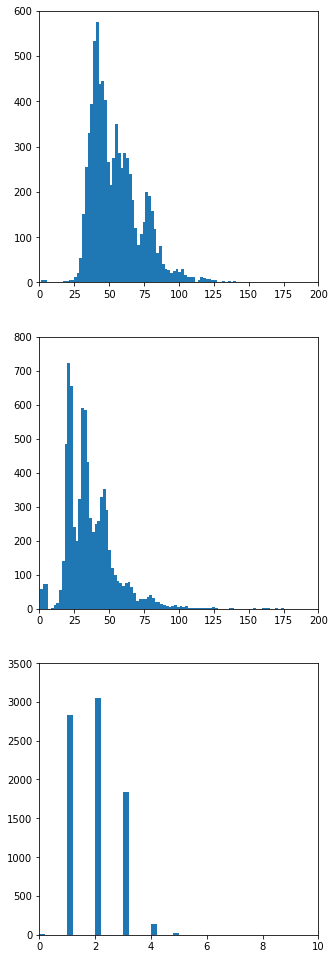

In [32]:
fig, ax = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(5,17)
ax1, ax2, ax3 = ax.flatten()

ax1.hist(tmp_notnull_square.Square, bins=325)
ax1.axis([0, 200, 0, 600])

ax2.hist(tmp_notnull_square.LifeSquare, bins=325)
ax2.axis([0, 200, 0, 800])

ax3.hist(tmp_notnull_square.Rooms, bins=25)
ax3.axis([0, 10, 0, 3500])

[0, 150, 0, 150]

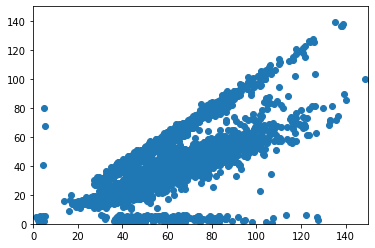

In [33]:
plt.scatter(tmp_notnull_square['Square'], tmp_notnull_square['LifeSquare'])
plt.axis([0, 150, 0, 150])

Комментарии и гипотезы по признаку LifeSquare: признак LifeSquare лучше всего коррелирует с Square. При этом если заглянуть внутрь зависимости - видно, что есть три ярко выраженных вектора, т.е. есть 3 группы экземпляров, в каждой из которых зависимость выражается своей линейной функцией. Если получится найти способ кластеризовать без участия LifeSquare так чтобы модель качественно разделила эти 3 луча, то получится дополнить данные ощутимо качесвенней чем просто "сбросить в медиану".

Пробую несколько моделей кластеризации, в т.ч. с предварительным понижением размерности:

In [34]:
tmp_notnull_square

scaler = StandardScaler()
tmp_scaled = pd.DataFrame(scaler.fit_transform(tmp_notnull_square), columns=tmp_notnull_square.columns)

tsne = TSNE(n_components=3, learning_rate=150, random_state=100)
tmp_tsne = tsne.fit_transform(tmp_scaled)

KMeans:

In [35]:
kmeans = KMeans(n_clusters=3)
labels_tmp = kmeans.fit_predict(tmp_tsne)  # 2D

In [36]:
kmeans_3 = KMeans(n_clusters=3)
labels_tmp_3 = kmeans_3.fit_predict(tmp_scaled)  # 3D

AgglomerativeClustering:

In [37]:
agglomerative_model = AgglomerativeClustering(n_clusters=3)
agg_labels = agglomerative_model.fit_predict(tmp_tsne)

In [38]:
agglomerative_model_3 = AgglomerativeClustering(n_clusters=3)
agg_labels_3 = agglomerative_model_3.fit_predict(tmp_tsne)

(0, 125)

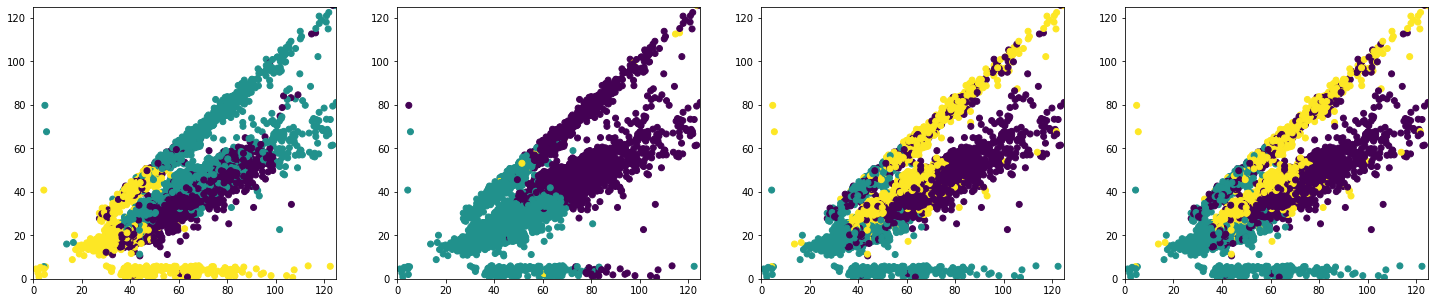

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=4)
ax1, ax2, ax3, ax4 = ax.flatten()
fig.set_size_inches(25, 5)


ax1.scatter(tmp_notnull_square['Square'], tmp_notnull_square['LifeSquare'], c=labels_tmp)
ax1.set_xlim([0, 125])
ax1.set_ylim([0, 125])

ax2.scatter(tmp_notnull_square['Square'], tmp_notnull_square['LifeSquare'], c=labels_tmp_3)
ax2.set_xlim([0, 125])
ax2.set_ylim([0, 125])

ax3.scatter(tmp_notnull_square['Square'], tmp_notnull_square['LifeSquare'], c=agg_labels)
ax3.set_xlim([0, 125])
ax3.set_ylim([0, 125])

ax4.scatter(tmp_notnull_square['Square'], tmp_notnull_square['LifeSquare'], c=agg_labels_3)
ax4.set_xlim([0, 125])
ax4.set_ylim([0, 125])

Можно определять принадлежность к кластеру (а следовательно и формулу зависимости LifeSquare от Square) по первому варианту кластеризации, либо по третьему, либо по их комбинации, либо на основе этих вариантов (например, "верить" определенному подходу на определенных диапзонах и т.д.)

In [40]:
def m_lifefloor_fillna_10(param):
    global train, test
    if param == 'to_median':
        train.loc[train['LifeSquare'].isnull(), 'LifeSquare'] = train['LifeSquare'].median()
        test.loc[test['LifeSquare'].isnull(), 'LifeSquare'] = test['LifeSquare'].median()
    if param == 'smart':
        pass

if cell_by_cell: m_lifefloor_fillna_10('to_median')

### Floor

(array([235.,   0., 588.,   0.,   0., 872.,   0.,   0., 949.,   0.,   0.,
        876.,   0.,   0., 802.,   0., 759.,   0.,   0., 643.,   0.,   0.,
        604.,   0.,   0., 553.,   0.,   0., 457.,   0., 438.,   0.,   0.,
        398.,   0.,   0., 362.,   0.,   0., 287.,   0.,   0., 290.,   0.,
        256.,   0.,   0., 185.,   0.,   0., 121.,   0.,   0.,  68.,   0.,
          0.,  59.,   0.,  54.,   0.,   0.,  25.,   0.,   0.,  53.,   0.,
          0.,  34.,   0.,   0.,  18.,   0.,   5.,   0.,   0.,   3.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.]),
 array([ 1.        ,  1.35652174,  1.71304348,  2.06956522,  2.42608696,
         2.7826087 ,  3.13913043,  3.49565217,  3.85217391,  4.20869565,
         4.56521739,  4.92173913,  5.27826087,  5.63478261,  5.99130435,
 

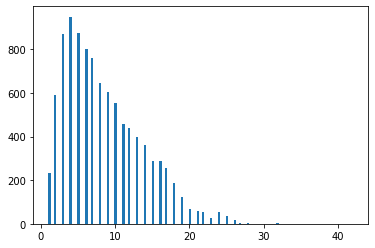

In [41]:
plt.hist(train['Floor'], bins=115)

### HouseFloor

In [42]:
tmp = train['Floor'] > train['HouseFloor']
tmp.value_counts()

False    8175
True     1825
dtype: int64

Много случаев когда указанный этаж квартиры выше этажности дома. В данном случае предполагаем, что этаж квартиры более близкое к истинному значение, а этажность дома "знают" не всегда, так что будем "исправлять" признак "этажность дома".

Посмотрим, как распределяется соотношение HoueFloor/Floor среди "нормальных" случаев (Floor <= HouseFloor).

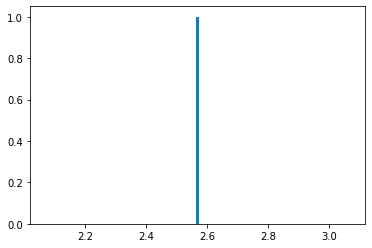

In [43]:
# Корректируем некорректные HouseFloor на медианое отношение HouseFloor/Floor по корректным комбинациям.
def m_floor_mistakes_process_7(param):
    global train, test
    if param == 'mode':
        tmp = train.loc[train['Floor'] < train['HouseFloor'], :]
        tmp_test = test.loc[test['Floor'] < test['HouseFloor'], :]

        k = (tmp['HouseFloor'] / tmp['Floor']).mean()
        k_test = (tmp_test['HouseFloor'] / tmp_test['Floor']).mean()

        plt.hist(k, bins=125)

        train.loc[train['Floor'] > train['HouseFloor'] ,'HouseFloor'] = train['Floor'] * k
        test.loc[test['Floor'] > test['HouseFloor'] ,'HouseFloor'] = test['Floor'] * k_test
    if param == 'floor':
        train.loc[train['Floor'] > train['HouseFloor'] ,'HouseFloor'] = train['Floor']
        test.loc[test['Floor'] > test['HouseFloor'] ,'HouseFloor'] = test['Floor']
    if param == 'drop':
        train.drop()
    

if cell_by_cell: m_floor_mistakes_process_7('mode')

### HouseYear

In [44]:
test.sort_values(by='HouseYear', ascending=False).head()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
385,13407,2.0,77.057476,70.454039,16.0,12,30.036413,2020,0.019509,1,1,37,7687,11,176.0,5,5,1
888,8560,2.0,57.979074,32.925087,10.0,7,20.000000,2020,0.178917,1,1,18,3594,4,192.0,1,5,1
4273,8311,1.0,38.747897,21.602020,8.0,15,24.000000,2020,0.049637,1,1,34,7759,0,229.0,1,3,1
1275,1276,2.0,54.491417,51.640968,1.0,5,12.515172,2020,0.005767,1,1,1,388,0,NaN,0,0,1
3382,651,1.0,40.108538,21.984746,8.0,12,24.000000,2020,0.049637,1,1,34,7759,0,229.0,1,3,1


In [45]:
train.sort_values(by='HouseYear', ascending=False).head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,1,1,30,6141,10,262.0,3,6,1,254084.534396
4189,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,1,1,25,4756,16,2857.0,5,8,1,243028.603096
5701,1.0,49.298503,51.135512,9.0,9,12.0,2020,0.072158,1,1,2,629,1,NaN,0,0,0,151779.182589
2493,1.0,35.672788,21.391266,8.0,4,24.0,2020,0.049637,1,1,34,7759,0,229.0,1,3,1,170847.416766
1499,2.0,85.087643,77.976325,10.0,7,10.0,2020,0.341072,1,1,27,5664,48,2300.0,3,11,1,536020.260344


In [46]:
def m_houseyear_outliers_7():
    global train, test
    edge_low = 1870
    edge_high = 2020
    train.loc[train['HouseYear'] < edge_low, 'HouseYear'] = edge_low
    train.loc[train['HouseYear'] > edge_high, 'HouseYear'] = edge_high
    test.loc[test['HouseYear'] < edge_low, 'HouseYear'] = edge_low
    test.loc[test['HouseYear'] > edge_high, 'HouseYear'] = edge_high

if cell_by_cell: m_houseyear_outliers_7()

### Price

(array([ 171.,  430.,  692., 1060., 1356., 1564., 1171.,  844.,  603.,
         420.,  324.,  272.,  240.,  191.,  141.,  114.,   99.,   75.,
          68.,   52.,   36.,   25.,   21.,   15.,   16.]),
 array([ 59174.77802758,  82137.12556928, 105099.47311097, 128061.82065267,
        151024.16819436, 173986.51573605, 196948.86327775, 219911.21081944,
        242873.55836114, 265835.90590283, 288798.25344453, 311760.60098622,
        334722.94852792, 357685.29606961, 380647.64361131, 403609.991153  ,
        426572.3386947 , 449534.68623639, 472497.03377808, 495459.38131978,
        518421.72886147, 541384.07640317, 564346.42394486, 587308.77148656,
        610271.11902825, 633233.46656995]),
 <a list of 25 Patch objects>)

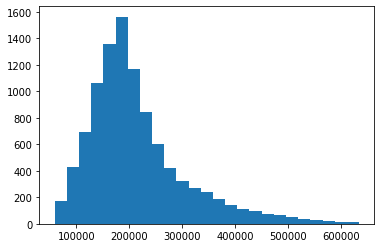

In [47]:
plt.hist(train['Price'], bins=25)  # Выглядит ОК.

### Healthcare_1

In [48]:
train.corr()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Rooms,1.000000,0.683614,0.471558,0.111640,-0.004356,-0.015630,-0.043454,-0.031687,-0.002333,-0.006601,0.078543,0.073338,0.014146,0.044498,0.065042,0.054932,-0.001070,0.568800
Square,0.683614,1.000000,0.656605,0.106245,0.114791,0.124228,0.179489,-0.064479,0.029926,0.022748,-0.070690,-0.043120,0.035241,-0.039748,-0.022960,0.021357,-0.049380,0.520075
LifeSquare,0.471558,0.656605,1.000000,0.073721,0.072385,0.074154,0.171229,-0.048770,0.020237,0.020692,-0.077868,-0.058154,0.047407,-0.018423,-0.032185,0.022075,-0.019566,0.330839
KitchenSquare,0.111640,0.106245,0.073721,1.000000,-0.011088,-0.057142,0.167493,0.020167,-0.006117,-0.056622,0.278176,0.255075,-0.059306,0.098320,0.153626,0.076590,0.022466,0.247940
Floor,-0.004356,0.114791,0.072385,-0.011088,1.000000,0.675540,0.284180,-0.016133,0.049661,0.025767,-0.044914,-0.016560,-0.002237,-0.138294,-0.065537,0.024264,-0.013626,0.128715
HouseFloor,-0.015630,0.124228,0.074154,-0.057142,0.675540,1.000000,0.302688,-0.029926,0.057147,0.026887,-0.074249,-0.040049,0.007035,-0.138310,-0.084077,0.020763,-0.044775,0.102727
HouseYear,-0.043454,0.179489,0.171229,0.167493,0.284180,0.302688,1.000000,-0.065987,0.076826,0.047215,-0.047870,0.013629,-0.049274,-0.204607,-0.115552,-0.001892,-0.058704,0.036735
Ecology_1,-0.031687,-0.064479,-0.048770,0.020167,-0.016133,-0.029926,-0.065987,1.000000,-0.110725,-0.223197,0.026464,0.009264,-0.124068,-0.043547,0.030873,-0.076749,0.079809,-0.058381
Ecology_2,-0.002333,0.029926,0.020237,-0.006117,0.049661,0.057147,0.076826,-0.110725,1.000000,-0.016643,-0.066017,-0.012709,0.008512,-0.031724,-0.082667,0.051892,0.022242,0.022379
Ecology_3,-0.006601,0.022748,0.020692,-0.056622,0.025767,0.026887,0.047215,-0.223197,-0.016643,1.000000,-0.037777,0.007394,0.014595,-0.114715,-0.133120,0.001859,-0.050425,-0.052585


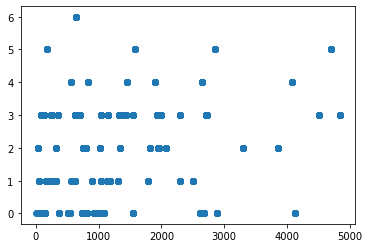

In [49]:
plt.scatter(train['Healthcare_1'], train['Helthcare_2'])

(array([1354., 1277., 1224.,  314.,  409.,  369.,   43.,   42.,   82.,
          88.]),
 array([   0. ,  484.9,  969.8, 1454.7, 1939.6, 2424.5, 2909.4, 3394.3,
        3879.2, 4364.1, 4849. ]),
 <a list of 10 Patch objects>)

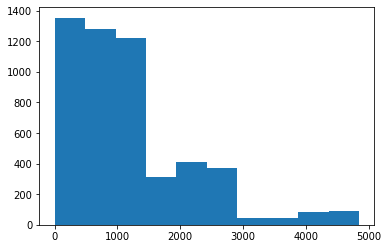

In [50]:
plt.hist(train.loc[train['Healthcare_1'].notnull() ,'Healthcare_1'])

In [51]:
def m_healthcare1_fillna_9(param):
    global train, test
    if param == 'fill':
        train.loc[train['Healthcare_1'].isnull() ,'Healthcare_1'] =\
        train.loc[train['Healthcare_1'].notnull() ,'Healthcare_1'].median()

        test.loc[test['Healthcare_1'].isnull() ,'Healthcare_1'] =\
        test.loc[test['Healthcare_1'].notnull() ,'Healthcare_1'].median()
    if param == 'drop':
        train.drop(columns=['Healthcare_1'], inplace=True)
        test.drop(columns=['Healthcare_1'], inplace=True)
    
if cell_by_cell: m_healthcare1_fillna_9('fill')

### Добавляю признаки:

In [52]:
def o_add_medprice_2():
    global train, test
    med_price_by_district = train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                           .rename(columns={'Price':'MedPriceByDistrict'})
    train = train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

    test = test.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
    test.loc[test['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = test['MedPriceByDistrict'].median()

#o_add_medprice_2()

### Масштабирование:

In [53]:
def m_scale_11(param):
    global train, test
    if param == 'standart':
        scaler = StandardScaler()
        train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
        ids = test['Id']
        test.drop(columns=['Id'], inplace=True)
        test = pd.DataFrame(scaler.fit_transform(test), columns=test.columns)
        test['Id'] = ids

if cell_by_cell: m_scale_11('standart') 

In [54]:
test.head(5)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Id
0,0.114525,-0.343979,-0.128993,0.030077,-0.480057,-0.228862,-0.667299,1.585280,0.098453,0.175258,-0.794834,-0.660397,-0.304366,-0.168811,-0.891612,-0.888194,0.299666,725
1,0.114525,0.671194,-0.160896,-0.999962,-0.480057,-0.128958,-0.398066,-0.367283,0.098453,0.175258,-1.080052,-0.986014,-0.220549,-0.168811,-0.891612,-0.469511,0.299666,15856
2,-1.119584,-2.244616,-1.227699,1.266125,-1.209627,-1.111920,-4.059632,-0.998468,0.098453,0.175258,0.288994,0.529306,3.299785,4.791278,2.487242,0.158513,0.299666,5480
3,0.114525,0.869374,1.034030,0.648101,2.438224,0.556078,1.217331,-0.149940,0.098453,0.175258,-0.110311,-0.204634,-0.220549,-0.168811,1.135700,-0.260169,0.299666,15664
4,-1.119584,-0.467364,0.496553,-0.999962,1.526261,0.065490,1.755796,-0.397445,0.098453,0.175258,-1.308227,-1.186699,-0.304366,-0.168811,-0.891612,-0.888194,-3.337053,14275


In [55]:
def m_tofile_14():
    train.to_csv('train_scaled.csv')
    test.to_csv('test_scaled.csv')
    
if cell_by_cell: m_tofile_14()

### Конструктор для формирования вариаций предобработки для оценки влияния разных вариантов предобработки:

In [ ]:
def main(outliers_param='to_median'):
    m_fill_datasets_0()
    m_del_id_from_train_1()
    m_replace_nominative_with_binary_2()
    #o_add_medprice_2()  # optional - ухудшает.
    m_process_districtid_3('delete')  # delete/dummy
    m_rooms_outliers_process_5(outliers_param, edge=5)  # to_edge/to_median/delete
    m_lifesquare_process_outliers_6(outliers_param, edge=1000)  # to_edge/to_median/delete
    m_kitchensquare_process_outliers_6(outliers_param, edge=150)  # to_edge/to_median/delete
    #m_floor_mistakes_process_7('floor')  # floor/mode - все испробованные варианты корректировки ухудшают.
    m_houseyear_outliers_7()
    m_healthcare1_fillna_9('fill')  # fill/drop
    m_lifefloor_fillna_10('to_median')  # to_median
    #m_scale_11('standart')  # standart
    m_tofile_14()
    
    
if not cell_by_cell:
    main()

In [ ]:
main('to_median')